# LSD Line Matching

This notebook demonstrates line segment detection and matching using LSD (Line Segment Detector) and Binary Descriptors in OpenCV. It replicates logic from a MATLAB example, detecting lines, computing descriptors, filtering by octave, and matching.

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [41]:
# Define paths to the template and reference images
template_base_folder = "/Users/frbuccoliero/Desktop/Thesis/Tests/utils/wikiCommonsOutput/png/"
reference_image_path = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00000.jpg"

template_image_path = None
if os.path.exists(template_base_folder) and os.path.isdir(template_base_folder):
    potential_templates = sorted([
        os.path.join(template_base_folder, f) 
        for f in os.listdir(template_base_folder) 
        if f.lower().endswith(".png")
    ])
    if potential_templates:
        template_image_path = potential_templates[8]
        print(f"Using template image: {template_image_path}")
    else:
        print(f"No PNG template images found in {template_base_folder}. Please set 'template_image_path' manually.")
else:
    print(f"Template folder '{template_base_folder}' does not exist. Please set 'template_image_path' manually.")

# Parameters inspired by the MATLAB example
LSD_SCALE = 2  # Scale of the image pyramid
LSD_NUM_OCTAVES = 2  # Number of octaves in the image pyramid
TARGET_OCTAVE_IDX = 1  # Octave index to filter keylines (0-indexed in Python)
MATCHES_DIST_THRESHOLD = 50.0  # Hamming distance threshold for good matches

Using template image: /Users/frbuccoliero/Desktop/Thesis/Tests/utils/wikiCommonsOutput/png/Aquatic-pollut-red.png


Template image 'Aquatic-pollut-red.png' loaded successfully.
Reference image 'positive_00000.jpg' loaded successfully.


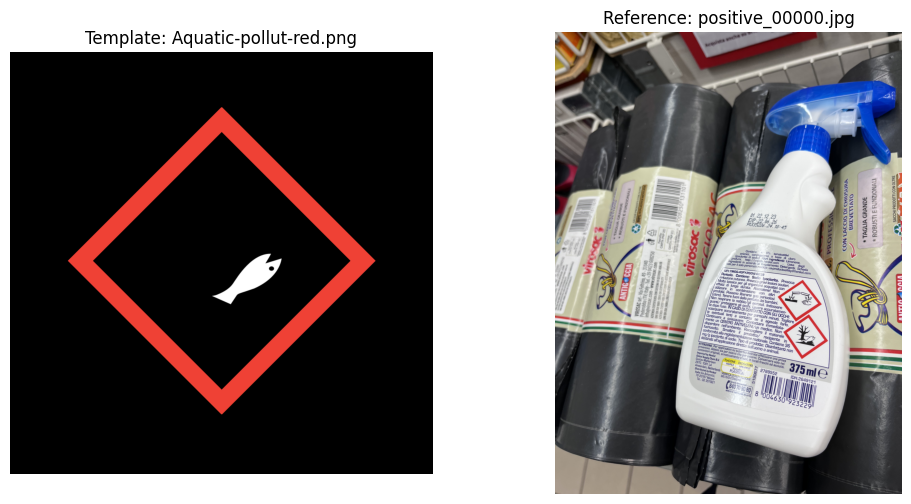

In [42]:
# Load images
img1_orig = None
img2_orig = None
img1_gray = None
img2_gray = None

if template_image_path and os.path.exists(template_image_path):
    img1_orig = cv2.imread(template_image_path)
    if img1_orig is not None:
        img1_gray = cv2.cvtColor(img1_orig, cv2.COLOR_BGR2GRAY)
        print(f"Template image '{os.path.basename(template_image_path)}' loaded successfully.")
    else:
        print(f"Error loading template image: {template_image_path}")
else:
    print(f"Template image path is not valid or not set: {template_image_path}")

if os.path.exists(reference_image_path):
    img2_orig = cv2.imread(reference_image_path)
    if img2_orig is not None:
        img2_gray = cv2.cvtColor(img2_orig, cv2.COLOR_BGR2GRAY)
        print(f"Reference image '{os.path.basename(reference_image_path)}' loaded successfully.")
    else:
        print(f"Error loading reference image: {reference_image_path}")
else:
    print(f"Reference image path does not exist: {reference_image_path}")

if img1_gray is None or img2_gray is None:
    print("One or both images could not be loaded. Halting execution.")
    # In a real script, you might raise an error or exit here.
else:
    # Optionally display loaded images
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB))
    plt.title(f"Template: {os.path.basename(template_image_path)}")
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
    plt.title(f"Reference: {os.path.basename(reference_image_path)}")
    plt.axis('off')
    plt.show()

In [ ]:
# Initialize LSD Detector, Binary Descriptor Extractor, and Matcher
lsd = cv2.line_descriptor.LSDDetector.createLSDDetector()
bd = cv2.line_descriptor.BinaryDescriptor.createBinaryDescriptor()
bdm = cv2.line_descriptor.BinaryDescriptorMatcher()

print("LSD Detector, Binary Descriptor, and Matcher initialized.")

LSD Detector, Binary Descriptor, and Matcher initialized.


In [44]:
# Detect lines and compute descriptors

keylines1, descr1 = None, None
keylines2, descr2 = None, None

if img1_gray is not None:
    # Detect lines in the template image
    keylines1_raw = lsd.detect(img1_gray,scale=LSD_SCALE, numOctaves=LSD_NUM_OCTAVES,  mask=None)
    # Compute descriptors for the detected lines
    # The 'compute' method might filter some keylines if descriptors cannot be computed for them.
    if keylines1_raw and len(keylines1_raw) > 0:
        keylines1, descr1 = bd.compute(img1_gray, keylines1_raw)
        print(f"Template: Detected {len(keylines1_raw)} raw lines. Computed {len(descr1) if descr1 is not None else 0} descriptors for {len(keylines1) if keylines1 is not None else 0} lines.")
    else:
        print("Template: No raw lines detected.")
else:
    print("Template grayscale image is not available for line detection.")

if img2_gray is not None:
    # Detect lines in the reference image
    keylines2_raw = lsd.detect(img2_gray,scale=LSD_SCALE, numOctaves=LSD_NUM_OCTAVES, mask=None)
    # Compute descriptors for the detected lines
    if keylines2_raw and len(keylines2_raw) > 0:
        keylines2, descr2 = bd.compute(img2_gray, keylines2_raw)
        print(f"Reference: Detected {len(keylines2_raw)} raw lines. Computed {len(descr2) if descr2 is not None else 0} descriptors for {len(keylines2) if keylines2 is not None else 0} lines.")
    else:
        print("Reference: No raw lines detected.")
else:
    print("Reference grayscale image is not available for line detection.")

if (descr1 is None or len(descr1) == 0) or (descr2 is None or len(descr2) == 0):
    print("Not enough descriptors found in one or both images. Cannot proceed with matching.")

Template: Detected 39 raw lines. Computed 39 descriptors for 39 lines.
Reference: Detected 9321 raw lines. Computed 9321 descriptors for 9321 lines.


Plotting 39 lines on template image.
Plotting 9321 lines on reference image.


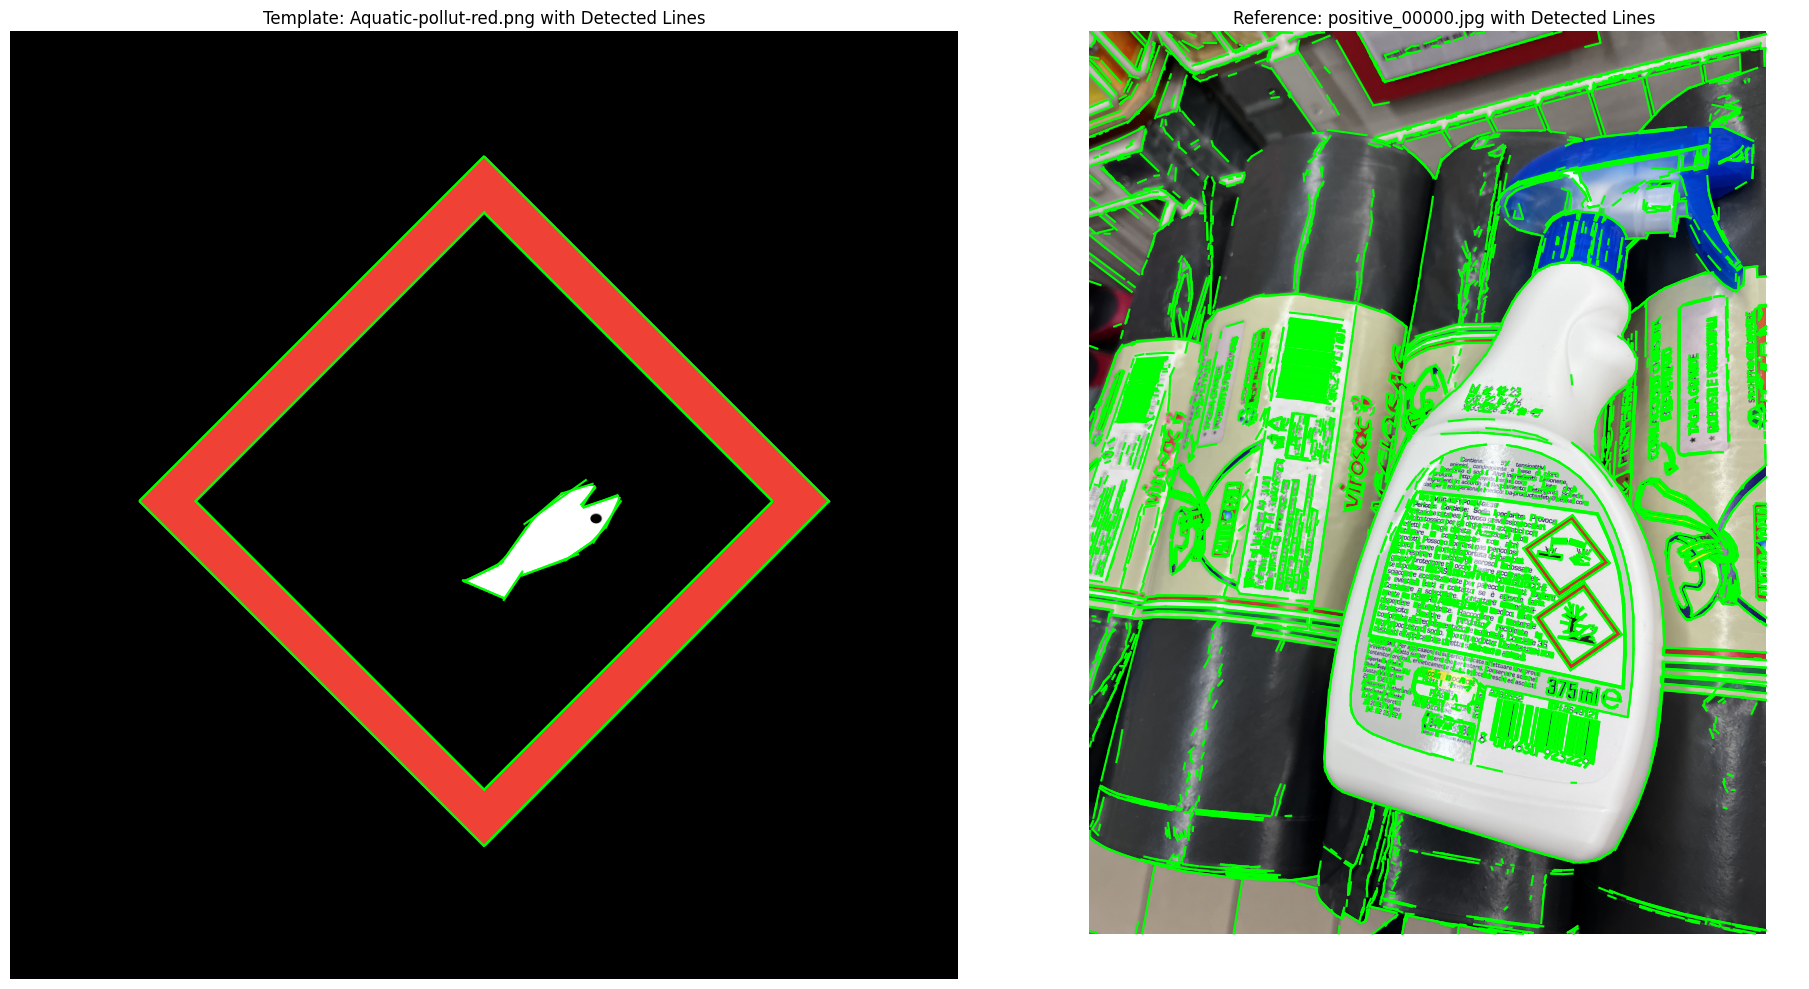

In [45]:
# Show lines in both images

if img1_orig is not None and img2_orig is not None:
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot lines on the first image (template)
    ax1 = axes[0]
    ax1.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB))
    ax1.set_title(f'Template: {os.path.basename(template_image_path)} with Detected Lines')
    ax1.axis('off')
    if keylines1_raw and len(keylines1_raw) > 0:
        print(f"Plotting {len(keylines1_raw)} lines on template image.")
        for kl in keylines1_raw:
            pt1 = (kl.startPointX, kl.startPointY)
            pt2 = (kl.endPointX, kl.endPointY)
            ax1.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='lime', linewidth=1.5)
    else:
        print("No lines detected in template image to plot.")

    # Plot lines on the second image (reference)
    ax2 = axes[1]
    ax2.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
    ax2.set_title(f'Reference: {os.path.basename(reference_image_path)} with Detected Lines')
    ax2.axis('off')
    if keylines2_raw and len(keylines2_raw) > 0:
        print(f"Plotting {len(keylines2_raw)} lines on reference image.")
        for kl in keylines2_raw:
            pt1 = (kl.startPointX, kl.startPointY)
            pt2 = (kl.endPointX, kl.endPointY)
            ax2.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='lime', linewidth=1.5)
    else:
        print("No lines detected in reference image to plot.")

    plt.tight_layout()
    plt.show()
else:
    print("One or both original images are not loaded. Cannot plot detected lines.")



In [46]:
# Filter keylines and descriptors by the target octave

keylines1_oct, descr1_oct = [], None
keylines2_oct, descr2_oct = [], None

if keylines1 is not None and descr1 is not None and len(descr1) > 0:
    filtered_indices1 = [i for i, kl in enumerate(keylines1) if kl.octave == TARGET_OCTAVE_IDX]
    if filtered_indices1:
        keylines1_oct = [keylines1[i] for i in filtered_indices1]
        descr1_oct = descr1[filtered_indices1]
    print(f"Template: {len(keylines1_oct)} lines selected from octave {TARGET_OCTAVE_IDX}.")
else:
    print(f"Template: No descriptors available to filter for octave {TARGET_OCTAVE_IDX}.")

if keylines2 is not None and descr2 is not None and len(descr2) > 0:
    filtered_indices2 = [i for i, kl in enumerate(keylines2) if kl.octave == TARGET_OCTAVE_IDX]
    if filtered_indices2:
        keylines2_oct = [keylines2[i] for i in filtered_indices2]
        descr2_oct = descr2[filtered_indices2]
    print(f"Reference: {len(keylines2_oct)} lines selected from octave {TARGET_OCTAVE_IDX}.")
else:
    print(f"Reference: No descriptors available to filter for octave {TARGET_OCTAVE_IDX}.")

if (descr1_oct is None or len(descr1_oct) == 0) or \
   (descr2_oct is None or len(descr2_oct) == 0):
    print(f"Not enough descriptors in octave {TARGET_OCTAVE_IDX} for one or both images. Cannot proceed with matching.")

Template: 18 lines selected from octave 1.
Reference: 2620 lines selected from octave 1.


In [47]:
# Match descriptors from the selected octave
matches = []
if descr1_oct is not None and descr2_oct is not None and \
   len(descr1_oct) > 0 and len(descr2_oct) > 0:
    matches = bdm.match(descr1_oct, descr2_oct)
    print(f"Found {len(matches)} matches between octave {TARGET_OCTAVE_IDX} descriptors.")
else:
    print(f"Skipping matching due to lack of descriptors in octave {TARGET_OCTAVE_IDX} for one or both images.")

Found 18 matches between octave 1 descriptors.


Total good matches: 18. Plotting top 18 matches.


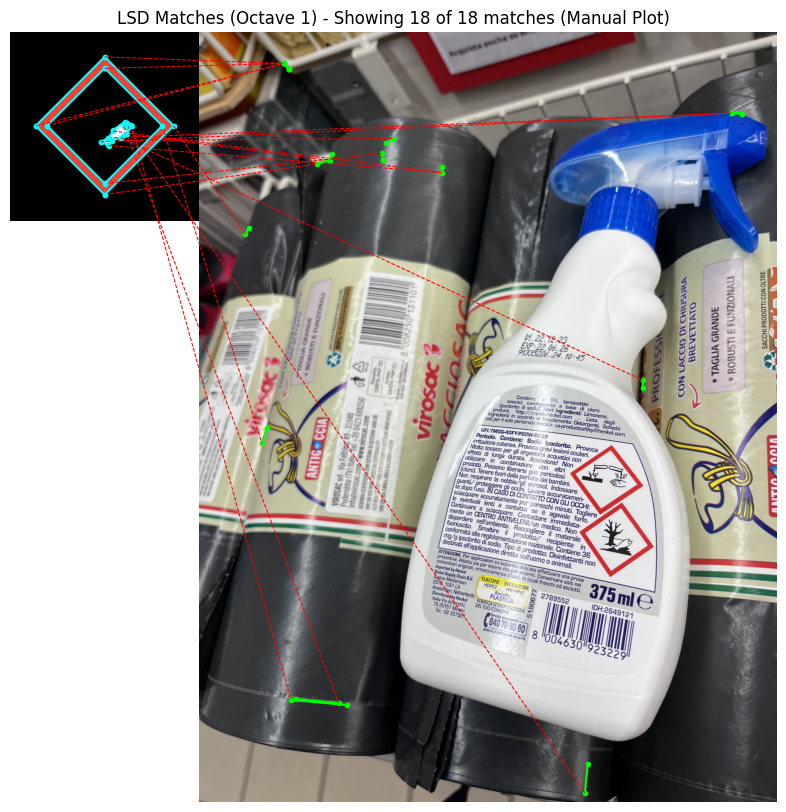

In [48]:
# Draw and display all matches

MAX_MATCHES_TO_DISPLAY = 50 # Limit the number of matches to display

if img1_orig is not None and img2_orig is not None and \
   keylines1_oct and keylines2_oct and matches:

    # Get dimensions
    h1, w1 = img1_orig.shape[:2]
    h2, w2 = img2_orig.shape[:2]
    
    # Create a figure to plot
    fig, ax = plt.subplots(1, 1, figsize=(20, 10)) # Adjust figure size as needed
    
    # Display the first image (template)
    ax.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB), extent=(0, w1, h1, 0)) # (left, right, bottom, top)
    
    # Display the second image (reference) offset by the width of the first image
    ax.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB), extent=(w1, w1 + w2, h2, 0)) # (left, right, bottom, top)

    # Limit the number of matches to draw
    matches_to_plot = matches[:MAX_MATCHES_TO_DISPLAY]
    print(f"Total good matches: {len(matches)}. Plotting top {len(matches_to_plot)} matches.")

    for match in matches_to_plot:
        # Get keylines involved in the match
        kl1 = keylines1_oct[match.queryIdx]
        kl2 = keylines2_oct[match.trainIdx]

        # Coordinates for the first keyline (on img1_orig)
        pt1_start = (kl1.startPointX, kl1.startPointY)
        pt1_end = (kl1.endPointX, kl1.endPointY)

        # Coordinates for the second keyline (on img2_orig)
        # These need to be offset by w1 for plotting on the combined image
        pt2_start = (kl2.startPointX + w1, kl2.startPointY)
        pt2_end = (kl2.endPointX + w1, kl2.endPointY)

        # Draw the line segment from img1
        ax.plot([pt1_start[0], pt1_end[0]], [pt1_start[1], pt1_end[1]], 
                color='cyan', linewidth=1.5, marker='o', markersize=3)
        
        # Draw the line segment from img2
        ax.plot([pt2_start[0], pt2_end[0]], [pt2_start[1], pt2_end[1]], 
                color='lime', linewidth=1.5, marker='o', markersize=3)
        
        # Draw a line connecting the start points of the matched lines
        ax.plot([pt1_start[0], pt2_start[0]], [pt1_start[1], pt2_start[1]], 
                color='red', linewidth=0.75, linestyle='--')

    ax.set_xlim(0, w1 + w2)
    ax.set_ylim(max(h1, h2), 0) # Inverted y-axis for images
    ax.axis('off')
    title_str = f'LSD Matches (Octave {TARGET_OCTAVE_IDX}) - Showing {len(matches_to_plot)} of {len(matches)} matches (Manual Plot)'
    plt.title(title_str)
    plt.show()

elif not matches:
    print("No good matches to display.")
else:
    print("One or more components (images, keylines) are missing for displaying matches.")


In [49]:
# Filter good matches based on distance threshold
good_matches = []
if matches: # Ensure matches list is not empty
    good_matches = [m for m in matches if m.distance < MATCHES_DIST_THRESHOLD]
    print(f"Number of good matches (distance < {MATCHES_DIST_THRESHOLD}): {len(good_matches)}")
    
    # Optional: Sort them by distance
    good_matches = sorted(good_matches, key=lambda x: x.distance)
else:
    print("No matches found to filter.")

Number of good matches (distance < 50.0): 13


Total good matches: 13. Plotting top 13 matches.


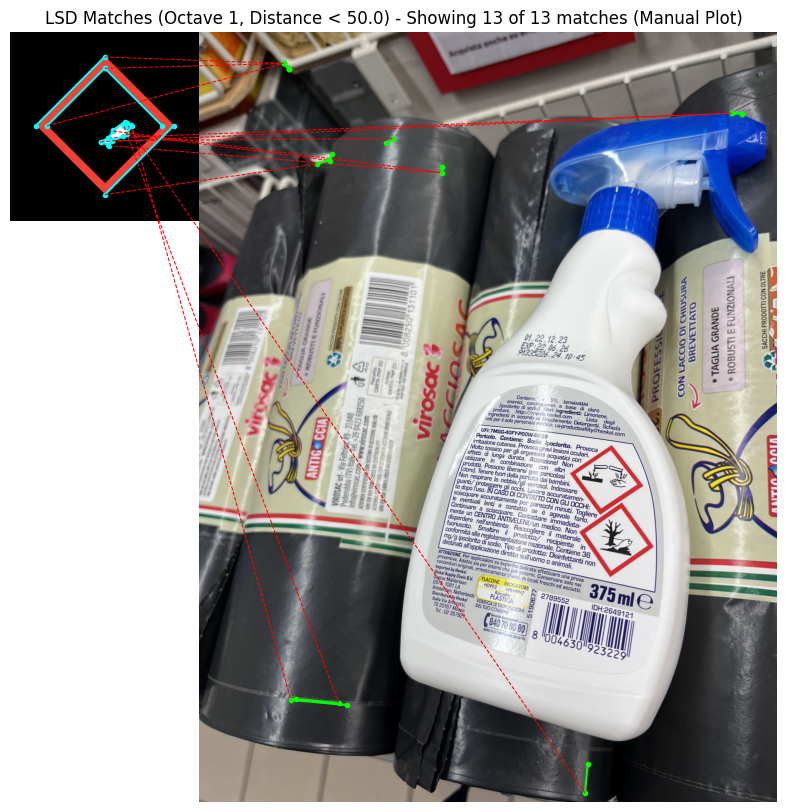

In [50]:
# Draw and display matches

MAX_MATCHES_TO_DISPLAY = 50 # Limit the number of matches to display

if img1_orig is not None and img2_orig is not None and \
   keylines1_oct and keylines2_oct and good_matches:

    # Get dimensions
    h1, w1 = img1_orig.shape[:2]
    h2, w2 = img2_orig.shape[:2]
    
    # Create a figure to plot
    fig, ax = plt.subplots(1, 1, figsize=(20, 10)) # Adjust figure size as needed
    
    # Display the first image (template)
    ax.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB), extent=(0, w1, h1, 0)) # (left, right, bottom, top)
    
    # Display the second image (reference) offset by the width of the first image
    ax.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB), extent=(w1, w1 + w2, h2, 0)) # (left, right, bottom, top)

    # Limit the number of matches to draw
    matches_to_plot = good_matches[:MAX_MATCHES_TO_DISPLAY]
    print(f"Total good matches: {len(good_matches)}. Plotting top {len(matches_to_plot)} matches.")

    for match in matches_to_plot:
        # Get keylines involved in the match
        kl1 = keylines1_oct[match.queryIdx]
        kl2 = keylines2_oct[match.trainIdx]

        # Coordinates for the first keyline (on img1_orig)
        pt1_start = (kl1.startPointX, kl1.startPointY)
        pt1_end = (kl1.endPointX, kl1.endPointY)

        # Coordinates for the second keyline (on img2_orig)
        # These need to be offset by w1 for plotting on the combined image
        pt2_start = (kl2.startPointX + w1, kl2.startPointY)
        pt2_end = (kl2.endPointX + w1, kl2.endPointY)

        # Draw the line segment from img1
        ax.plot([pt1_start[0], pt1_end[0]], [pt1_start[1], pt1_end[1]], 
                color='cyan', linewidth=1.5, marker='o', markersize=3)
        
        # Draw the line segment from img2
        ax.plot([pt2_start[0], pt2_end[0]], [pt2_start[1], pt2_end[1]], 
                color='lime', linewidth=1.5, marker='o', markersize=3)
        
        # Draw a line connecting the start points of the matched lines
        ax.plot([pt1_start[0], pt2_start[0]], [pt1_start[1], pt2_start[1]], 
                color='red', linewidth=0.75, linestyle='--')

    ax.set_xlim(0, w1 + w2)
    ax.set_ylim(max(h1, h2), 0) # Inverted y-axis for images
    ax.axis('off')
    title_str = f'LSD Matches (Octave {TARGET_OCTAVE_IDX}, Distance < {MATCHES_DIST_THRESHOLD}) - Showing {len(matches_to_plot)} of {len(good_matches)} matches (Manual Plot)'
    plt.title(title_str)
    plt.show()

elif not good_matches:
    print("No good matches to display.")
else:
    print("One or more components (images, keylines) are missing for displaying matches.")
